# Emulator learning

In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import matplotlib.pyplot as plt
import numpy as np
import theano
import time

from delfi.simulator.Gauss import Gauss
from tqdm import tqdm

%matplotlib inline

n_params = 1
seed = 42
m = Gauss(dim=n_params, seed=seed, noise_cov=1.)
p = dd.Gaussian(m=0.*np.ones(n_params), 
                S=1.*np.eye(n_params),
                seed=seed)
p = dd.Uniform(lower=-5., upper=5., seed=seed)
s = ds.Identity()
g = dg.Default(model=m, prior=p, summary=s)

obs = 0.8 * np.ones((1,1))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Steps 1 and 2

Initial training of the emulator

In [2]:
import theano.tensor as tt

from delfi.inference.BaseInference import BaseInference
from delfi.neuralnet.Trainer import Trainer
from delfi.neuralnet.loss.regularizer import svi_kl_zero

class EmulatorTraining(BaseInference):
    def __init__(self, generator, obs=None, reg_lambda=0.01, seed=None, verbose=True, **kwargs):
        """Training algorithm for emulator

        Parameters
        ----------
        generator : generator instance
            Generator instance
        obs : array or None
            Observation in the format the generator returns (1 x n_summary)
        reg_lambda : float
            Precision parameter for weight regularizer if svi is True
        seed : int or None
            If provided, random number generator will be seeded
        kwargs : additional keyword arguments
            Additional arguments for the NeuralNet instance, including:
                n_components : int
                    Number of components of the mixture density
                n_hiddens : list of ints
                    Number of hidden units per layer of the neural network
                svi : bool
                    Whether to use SVI version of the network or not

        Attributes
        ----------
        observables : dict
            Dictionary containing theano variables that can be monitored while
            training the neural network.
        """
        super().__init__(generator, prior_norm=False,
                         pilot_samples=0, seed=seed,
                         verbose=verbose, **kwargs)
        self.obs = obs
        self.reg_lambda = reg_lambda

    def loss(self, N):
        """Loss function for training

        Parameters
        ----------
        N : int
            Number of training samples
        """
        loss = -tt.mean(self.network.lprobs)

        # keep weights close to zero-centered prior
        if self.reg_lambda > 0:
            kl, _ = svi_kl_zero(self.network.mps, self.network.sps,
                                self.reg_lambda)
        else:
            kl = 0.
        loss = loss + 1/N * kl

        return loss

    def acquisition(self, beta=1.):
        loss = - (tt.mean(self.network.lprobs) + beta*tt.var(self.network.lprobs)) 
        
        
    def run(self, n_train=100, epochs=100, minibatch=50, monitor=None,
            **kwargs):
        """Run algorithm

        Generate training data using the generator. Set up the Trainer with a
        neural net, a loss function and the generated training data. Train the
        network with the specified training arguments.

        Parameters
        ----------
        n_train : int
            Number of training samples
        epochs : int
            Number of epochs used for neural network training
        minibatch : int
            Size of the minibatches used for neural network training
        monitor : list of str
            Names of variables to record during training along with the value
            of the loss function. The observables attribute contains all
            possible variables that can be monitored
        kwargs : additional keyword arguments
            Additional arguments for the Trainer instance

        Returns
        -------
        log: dict
            dict containing the loss values as returned by Trainer.train()
        trn_data : (params, stats)
            training dataset, z-transformed
        posterior : distribution or None
            posterior for obs if obs is not None
        """
        trn_data = self.gen(n_train, verbose=self.verbose)  # z-transformed
        trn_inputs = [self.network.stats, self.network.params]  # flipped (!)

        t = Trainer(self.network, self.loss(N=n_train),
                    trn_data=trn_data, trn_inputs=trn_inputs,
                    monitor=self.monitor_dict_from_names(monitor),
                    seed=self.gen_newseed(), **kwargs)
        log = t.train(epochs=epochs, minibatch=minibatch, verbose=self.verbose)

        posterior = self.predict(self.obs) if self.obs is not None else None

        return log, trn_data, posterior

In [3]:
emul = EmulatorTraining(g, n_hiddens=[10], seed=seed, reg_lambda=0.1, var_init=0.01)
log, trn_data, _ = emul.run(100, epochs=2000)  # trn_data is (params, stats)

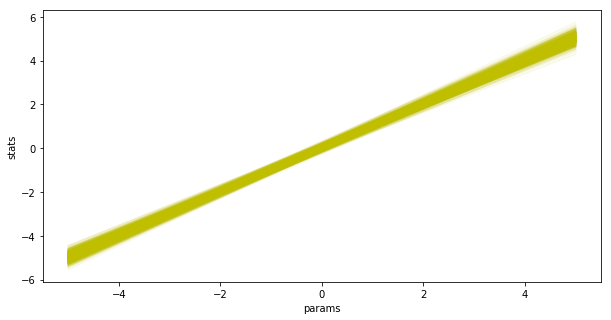

In [4]:
## posterior draws

res = 100
thetas = np.linspace(-5, 5, res)

R = 500

vals = np.zeros((res, R, 3))

for i, theta_e in enumerate(thetas):
    theta_e = theta_e * np.ones((1,1))
    theta_e = theta_e.astype(np.float32)

    for r in range(R):
        pred = emul.network.get_mog(theta_e, deterministic=False)
        vals[i, r, 0] = pred.xs[0].m
        vals[i, r, 1] = pred.xs[0].S
        vals[i, r, 2] = pred.xs[0].m.squeeze() + np.sqrt(pred.xs[0].S.squeeze())*np.random.randn()
    
## Posterior if we did linear regression on trn_data

params, stats = trn_data

alpha = 0.1  # precision of isotropic Gaussian prior on weight
betam = 1.  # precision of model noise

m0 = 0.
S0 = 1/alpha*np.eye(2)
Phi = np.array([params.squeeze(), 
                np.ones((len(params)))]).T
t = stats

SN = np.linalg.inv(alpha+betam*np.dot(Phi.T, Phi))
mN = betam*np.dot(SN, np.dot(Phi.T, t))

x = thetas

plt.figure(figsize=(10,5))

for r in range(R):
    sampam = np.random.multivariate_normal(mN.squeeze(), SN, 1)
    plt.plot(x, np.dot(sampam.squeeze(), np.array([x, 1])), '-y', alpha=0.1)

#plt.plot(thetas, vals[:, :, 0], '.b', alpha=0.2);
#plt.plot(thetas, vals[:, :, 1], '.g', alpha=0.2);

#plt.plot(params, stats, '.r')
plt.xlabel('params')
plt.ylabel('stats');

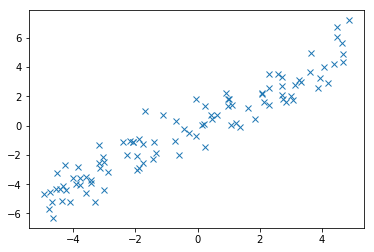

In [5]:
plt.plot(params, stats, 'x')

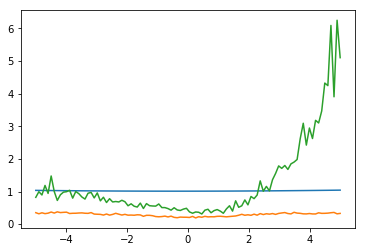

In [6]:
plt.plot(x, 1/betam + np.dot(np.dot(np.array([x, 1]), SN), np.array([x, 1])))

plt.plot(x, np.var(vals[:, :, 0], axis=1))

plt.plot(x, np.var(vals[:, :, 1], axis=1))

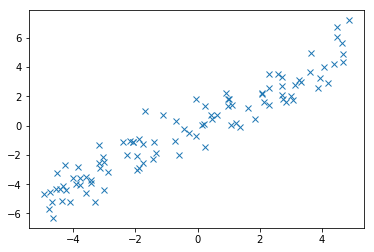

In [7]:
plt.plot(params, stats, 'x')

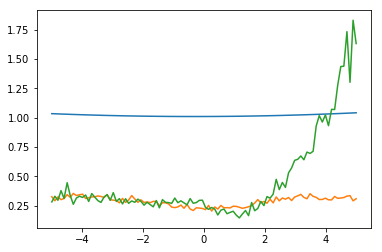

In [8]:
plt.plot(x, 1/betam + np.dot(np.dot(np.array([x, 1]), SN), np.array([x, 1])))

plt.plot(x, np.var(vals[:, :, 0], axis=1))

plt.plot(x, np.var(vals[:, :, 1], axis=1))

In [13]:
np.log(np.sqrt(0.01))

-2.3025850929940455

In [15]:
emul.network.params_dict

{'h1.mW': array([[-0.25952309, -0.33696809, -0.02665106, -0.93150306, -0.29457444,
         -0.67888671, -0.36480767, -0.59092653, -0.67300218, -0.97351158]], dtype=float32),
 'h1.mb': array([ 0.01111777, -0.16205233,  0.02199078,  0.82102776, -0.1549664 ,
        -0.95954251,  0.09065121,  0.88815653, -0.54193091, -0.54248452], dtype=float32),
 'h1.sW': array([[-3.01077127, -2.32086515,  1.04222488, -0.60297614, -2.26469469,
         -1.99081326, -1.74682474, -1.86511278, -0.13809454,  0.43251365]], dtype=float32),
 'h1.sb': array([-2.13506842, -1.46272206,  1.09092879,  0.21445757, -1.34549713,
        -1.13776243, -0.78129774, -0.93620914,  0.79467189,  1.03282404], dtype=float32),
 'imputation_values': array([ 0.01250807], dtype=float32),
 'means.mW0': array([[-1.36259651],
        [-0.8432762 ],
        [-0.00398921],
        [-0.1421068 ],
        [-0.68738508],
        [-0.68065017],
        [-0.35418829],
        [-0.59756124],
        [-0.00949318],
        [-0.03806346]], dty

## Step 3

In [7]:
dtype = [('f', 'float32'), ('g', 'float32')]

def normal_loglikelihood(mu, sd):
    def logp(x):
        return -0.5* ((x - mu) / sd)**2 - 0.5 * tt.log(2* np.pi) - tt.log(sd)
    return logp


def make_fun(): 
    eval = theano.function(
        inputs=[emul.network.params, emul.network.stats],
        outputs=[f_theta, fprime_theta],
        on_unused_input='ignore')
    def fun(x, t):
        f, g = eval(x, t)
        return np.array((f, g), dtype=dtype)    
    return fun

def make_invoke(M):
    def invoke(x, theta):
        v = np.zeros(M, dtype=dtype)
        for m in range(M):
            v[m] = fun(x, theta)
        return v
    return invoke

def loss(v, beta):
    Ef = v['f'].mean()
    Ef2 = (v['f']**2).mean()
    E2f = Ef**2
    return -Ef - beta * (Ef2 - E2f)

def grad(v, beta):
    return -(np.mean(v['g']) + 2 * beta * (np.dot(v['f'], v['g'])/M - np.mean(v['f'])*np.mean(v['g'])))

def optimize(f, po, maxiter=150, verbose=False):
    to, xo = po
    alpha = 0.01
    done = False
    ti = to
    Lo = np.inf
    i = 0
    
    if verbose:
        pbar = tqdm()
    
    while not done and i < maxiter:
        vi = f(xo, ti)
        L = loss(vi, beta)
        g = grad(vi, beta)
        #print(ti, g)
        assert not np.isinf(g)
        assert not np.isnan(g)
        
        ti -= alpha * g
        if np.abs(Lo - L) < 1e-6 * Lo + 1e-6:
            done = True
        Lo = L
        i += 1
        
        if verbose:
            pbar.update()
    return ti

In [8]:
M = 100
beta = 1.

f_theta = tt.sum(emul.network.lprobs) + tt.sum(normal_loglikelihood(p.mean[0], p.std[0])(emul.network.stats))
fprime_theta = tt.grad(f_theta, emul.network.stats)

fun = make_fun()

In [9]:
obs = 0.8 * np.ones((1,1))
theta_s = 0.8 * np.ones((1,1))
obs = obs.astype(np.float32)
theta_s = theta_s.astype(np.float32)

t_star = optimize(make_invoke(M), (theta_s, obs))
t_star

array([[ 0.40252307]], dtype=float32)

## Verify

-2.7000000000000002

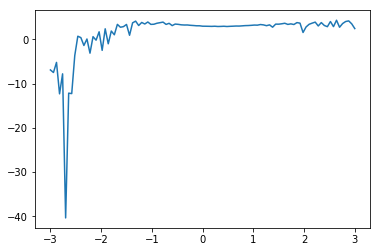

In [13]:
theta = np.linspace(-3,3,101)
invoke = make_invoke(M)
L = np.zeros(101)
for i, t in enumerate(theta):
    theta_s = np.array([[t]], dtype=np.float32)
    vi = invoke(obs, theta_s)
    L[i] = loss(vi, beta=1.)
    
plt.plot(theta, L)
theta[np.argmin(L)]